In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/ecommerce-data.csv', encoding='ISO-8859-1')

print("열 수 - {}, 행 수 - {}".format(len(df.columns), len(df)))
df.head()

열 수 - 8, 행 수 - 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 연도와 월로 나누기

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

set_of_year_month = list(set([(x.year, x.month) for x in df['InvoiceDate']]))
print(set_of_year_month)

[(2011, 10), (2011, 6), (2011, 3), (2011, 9), (2010, 12), (2011, 12), (2011, 2), (2011, 5), (2011, 11), (2011, 8), (2011, 4), (2011, 1), (2011, 7)]


### 데이터 분포 살피기

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

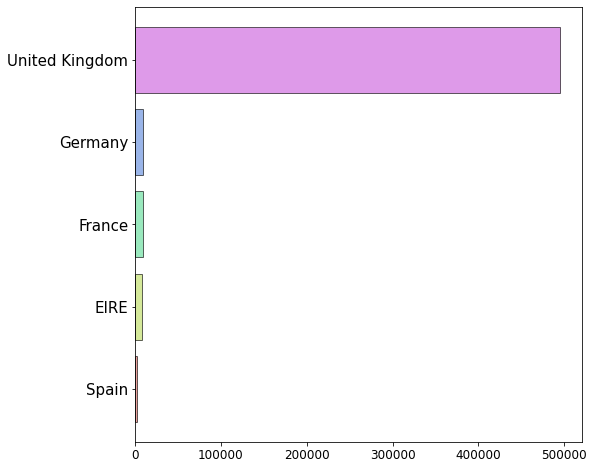

In [5]:
nation_data = Counter(df['Country']).most_common()
nation_data = nation_data[:5]

data = [x[1] for x in nation_data]
nations = [x[0] for x in nation_data]

nations.reverse()
data.reverse()

fig = plt.figure(figsize=(8,8))

fig.set_facecolor('white')
colors = sns.color_palette('hls', len(data))
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)

plt.barh(nations, data, color=colors, alpha=0.6, edgecolor='k')
plt.show()

### 데이터 전처리

In [6]:
import pandas as pd

df = pd.read_csv('./data/ecommerce-data.csv', encoding='ISO-8859-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 가장 많은 데이터와 2011년도 데이터 설정
target_country = 'United Kingdom'
target_year = 2011

df = df[(df['Country'] == target_country) & (df['InvoiceDate'].dt.year == target_year)]
need_cols = ['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']
df = df[need_cols]
df.dropna(inplace=True)

df = df[df['InvoiceNo'].str.get(0) != "C"]

print("열 수 - {}, 행 수 - {}".format(len(df.columns), len(df)))
df.head()

열 수 - 5, 행 수 - 330402


,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
42481,539993,10,2011-01-04 10:00:00,1.95,13313.0
42482,539993,25,2011-01-04 10:00:00,0.42,13313.0
42483,539993,25,2011-01-04 10:00:00,0.42,13313.0
42484,539993,5,2011-01-04 10:00:00,2.10,13313.0
42485,539993,10,2011-01-04 10:00:00,1.25,13313.0


### 데이터 분석

In [7]:
import pandas as pd
from tqdm import tqdm

customer_id = list(df['CustomerID'].unique())

#### 최근방문일 (Recently)

In [8]:
tmp_recency_df = df[['CustomerID', 'InvoiceDate']].drop_duplicates()
recency_df = tmp_recency_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df = recency_df.rename(columns={'InvoiceDate':'Recency'})

recency_df.head()

,CustomerID,Recency
0,12346.0,2011-01-18 10:01:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


#### 방문횟수 (Frequency)

In [10]:
tmp_frequency_df = df[['CustomerID', 'InvoiceNo']].drop_duplicates()
frequency_df = tmp_frequency_df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_df = frequency_df.rename(columns={'InvoiceNo':'Frequency'})

frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,9
2,12748.0,175
3,12749.0,5
4,12820.0,4


#### 구매액 (Monetary)

In [11]:
monetary_df = pd.DataFrame()
monetary_df['CustomerID'] = customer_id

monetary_data = []
for ci in tqdm(customer_id, position=0,desc='Calculating amount of individual customer'):
    tmp = df[df['CustomerID'] == ci]
    amount = sum(tmp['Quantity'] * tmp['UnitPrice'])
    monetary_data.append(amount)

monetary_df['Monetary'] = monetary_data
monetary_df.head()

Calculating amount of individual customer: 100%|█| 3814/3814 [00:03<00:00, 1060.


,CustomerID,Monetary
0,13313.0,1555.32
1,18097.0,2515.28
2,16656.0,8197.04
3,16875.0,2095.53
4,13094.0,1703.64


#### RFM

In [12]:
rfm_df = pd.merge(recency_df, frequency_df, how='left', on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, how='left', on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,1,77183.60
1,12747.0,2011-12-07 14:34:00,9,3489.74
2,12748.0,2011-12-09 12:20:00,175,29491.60
3,12749.0,2011-12-06 09:56:00,5,4090.88
4,12820.0,2011-12-06 15:12:00,4,942.34


### Recency 전처리
- rfm에서 현재 fm이 가지는 특성인, frequency와 monetary가 높을수록 큰 점수를 주는 것 처럼 최근방문일도 큰 값을 가질수록 큰 점수를 주기 위함
- 그래서 현재 데이터의 연도인 2011년 01월 01일을 기준으로 시간차이가 클수록 최근인 걸로

In [13]:
current_day = pd.to_datetime("20110101")
time_diff = rfm_df['Recency'] - current_day
time_in_secods = [x.total_seconds() for x in time_diff]
rfm_df['Recency'] = time_in_secods

In [14]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,1504860.0,1,77183.60
1,12747.0,29428440.0,9,3489.74
2,12748.0,29593200.0,175,29491.60
3,12749.0,29325360.0,5,4090.88
4,12820.0,29344320.0,4,942.34


#### Utils

In [15]:
def get_score(level, data):
    score = []
    for j in range(len(data)):
        for i in range(len(level)):
            if data[j] <= level[i]:
                score.append(i + 1)
                break
            elif data[j] > max(level):
                score.append(len(level) + 1)
                break
            else:
                continue
    
    return score

def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    for k,v in rfm_tick_point.items():
        if isinstance(v, str):
            if v == "quantile":
                scale = preprocessing.StandardScaler()
                tmp_data = np.array(df[rfm_col_map[k]])
                tmp_data = tmp_data.reshape((-1, 1))
                tmp_data = tmp_data.squeeze()
                
                quantiles_level = np.linspace(0, 1, num_class+1)[1: -1]
                quantiles = []
                for ql in quantiles_level:
                    quantiles.append(np.quantile(tmp_data, ql))
            else:
                tmp_data = np.array(df[rfm_col_map[k]])
                
                quantiles = np.linspace(np.min(tmp_data), np.max(tmp_data), num_class + 1)[1:-1]
        else:
            tmp_data = np.array(df[rfm_col_map[k]])
            quantiles = v
        score = get_score(quantiles, tmp_data)
        new_col_name = rfm_col_map[k] + '_' + k
        if suffix:
            new_col_name = rfm_col_map[k] + "_"+suffix
        df[new_col_name] = score
    return df

In [16]:
get_score([55, 85], [100, 85, 70, 60, 55])

[3, 2, 2, 2, 1]

In [17]:
rfm_tick_point = {'R': "quantile", 'F': "quantile", 'M': 'quantile'}
rfm_col_map = {'R': 'Recency', 'F': 'Frequency', 'M': 'Monetary'}

result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result.to_csv('result.csv', index=False)

In [18]:
result.head()

,CustomerID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,12346.0,1504860.0,1,77183.60,1,1,5
1,12747.0,29428440.0,9,3489.74,5,5,5
2,12748.0,29593200.0,175,29491.60,5,5,5
3,12749.0,29325360.0,5,4090.88,5,4,5
4,12820.0,29344320.0,4,942.34,5,4,4


#### RFM Strategy

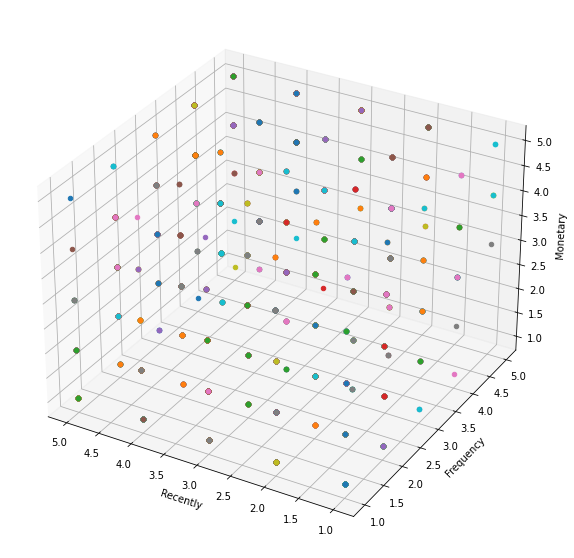

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# x - Recently, y - Frequency, z - Monetary
for idx, row in result.iterrows():
    r,f,m = row[-3:]
    ax.scatter(r,f,m)
    
ax.invert_xaxis()
ax.set_xlabel('Recently')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()